# Decision Tree

### DATA IS THE IMBALANCED DATA WITH SELECTED FEATURES 

In [7]:
#start with all dependencies

import numpy as np
import pandas as pd
from Evaluation import *
import sklearn
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.preprocessing import Imputer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
%matplotlib inline
import imblearn
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [8]:
#Read in the data as pandas dataframe
data = 'Statcast_data.csv'

def load_data(file):
    '''Load the Statcast_data.csv file into a pandas dataframe.
       Resolve unnecessary column in csv file'''
    baseball = pd.read_csv(file, index_col = 0)
    baseball['description'] = baseball['description'].replace({'blocked_ball': 0, 'ball': 0, "called_strike": 1})
    baseball['position_x'] = baseball['release_pos_x'] + baseball['pfx_x']
    baseball['position_z'] = baseball['release_pos_z'] + baseball['pfx_z']
    baseball['pitch_name'] = baseball['pitch_name'].replace('Knuckle Curve', 'Curveball')
    baseball = baseball[baseball.pitch_name != 'Eephus'] 
    
    final_df = baseball.loc[:, ['p_throws','pitch_name', 'position_x', 'position_z', 
                           'release_spin_rate', 'sz_top', 'sz_bot','vx0', 'vy0', 'vz0', 'description']]

    final_df=pd.get_dummies(final_df, prefix = 'pitch')
    final_df['player_name'] = baseball['player_name']
    
    final_df = final_df.dropna()
    return final_df


bsb = load_data(data)
X = bsb.drop(columns = ['player_name', 'description'])
y = bsb['description']

X.head()



,position_x,position_z,release_spin_rate,sz_top,sz_bot,vx0,vy0,vz0,pitch_L,pitch_R,pitch_2-Seam Fastball,pitch_4-Seam Fastball,pitch_Changeup,pitch_Curveball,pitch_Cutter,pitch_Sinker,pitch_Slider,pitch_Split Finger
0,4.9868,5.6846,2314.0,3.2971,1.5059,-9.8035,-138.1130,0.1339,1,0,1,0,0,0,0,0,0,0
1,4.1077,6.3981,2324.0,3.3136,1.5730,-9.0084,-140.5865,-2.4218,1,0,0,1,0,0,0,0,0,0
2,2.3349,4.9982,2521.0,3.9119,1.7080,-3.7285,-117.3223,1.2140,1,0,0,0,0,0,0,0,1,0
3,4.4509,6.1538,2329.0,3.5553,1.5639,-12.0533,-139.3669,-5.1407,1,0,0,1,0,0,0,0,0,0
4,4.5827,5.8014,2437.0,3.3450,1.6241,-14.0287,-139.8559,-3.3434,1,0,0,1,0,0,0,0,0,0


# Decision Tree
## 1: Without PCA
Without PCA

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 777)

tree = DecisionTreeClassifier(max_depth=4)
sampler = RandomUnderSampler(ratio = 1, random_state=777)

tree_pipe_no_pca = make_pipeline(sampler, tree)

tree_pipe_no_pca_results = cross_validate(tree_pipe_no_pca, X_train, y_train, 
                            scoring = ['accuracy', 'f1', 'roc_auc'], 
                            cv =5, return_estimator=True, return_train_score = True)

for result in ['train_accuracy', 'test_accuracy', 'train_f1', 'test_f1', 'train_roc_auc', 'test_roc_auc']:
    print(f"Mean {result} Value: {np.mean(tree_pipe_no_pca_results[result])}")
    print(f"{result} scores: {tree_pipe_no_pca_results[result]}")
    print() 

Mean train_accuracy Value: 0.46332551813867406
train_accuracy scores: [0.44090442 0.43327536 0.43468522 0.57494664 0.43281596]

Mean test_accuracy Value: 0.4612929460981494
test_accuracy scores: [0.4373353  0.43206493 0.43470012 0.57146622 0.43089817]

Mean train_f1 Value: 0.5108288214548465
train_f1 scores: [0.52417691 0.52251912 0.52022902 0.46474971 0.52246935]

Mean test_f1 Value: 0.5083560472110437
test_f1 scores: [0.52164172 0.52106667 0.51961662 0.45789719 0.52155803]

Mean train_roc_auc Value: 0.6100904676601655
train_roc_auc scores: [0.61625246 0.60773331 0.60891525 0.6101889  0.60736241]

Mean test_roc_auc Value: 0.6074908254308506
test_roc_auc scores: [0.61226555 0.60632686 0.59952069 0.60358011 0.61576092]



In [10]:
predictions = tree_pipe_no_pca_results['estimator'][0].predict(X_test)

def eval_test_set(x_test_predictions, y_test):
    print(f"Accuracy Score: {metrics.accuracy_score(y_test, x_test_predictions)}")
    print()
    print(f"AUC Score: {metrics.roc_auc_score(y_test, x_test_predictions)}")
    print()
    print(f"F1 Score: {metrics.f1_score(y_test, x_test_predictions)}")
    print()
    print(f"Classification Report: \n {metrics.classification_report(y_test, x_test_predictions)}")
    print()
    print(f" Confustion Matrix: \n {metrics.confusion_matrix(y_test, x_test_predictions)}")

eval_test_set(predictions, y_test)



Accuracy Score: 0.4387629257186225

AUC Score: 0.5745268412894057

F1 Score: 0.5232364476441197

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.19      0.32     21437
           1       0.36      0.96      0.52     10186

    accuracy                           0.44     31623
   macro avg       0.63      0.57      0.42     31623
weighted avg       0.73      0.44      0.38     31623


 Confustion Matrix: 
 [[ 4136 17301]
 [  447  9739]]


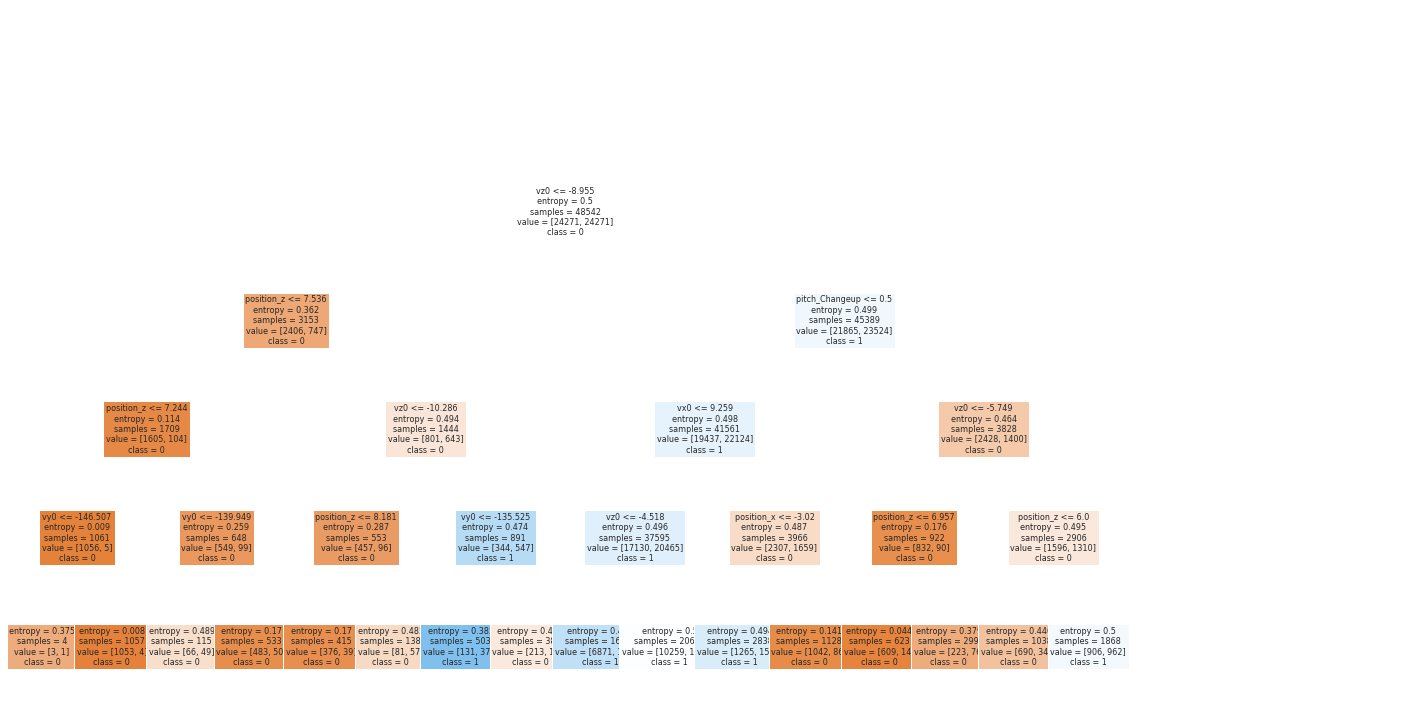

In [11]:
fig = plt.figure(figsize = (20, 10))
img = plot_tree(tree_pipe_no_pca_results['estimator'][0][1], feature_names=X_train.columns, 
                class_names = ['0', '1'], filled=True, fontsize = 8, 
               )
plt.tight_layout()
fig.savefig('images/base_decision_tree.png')


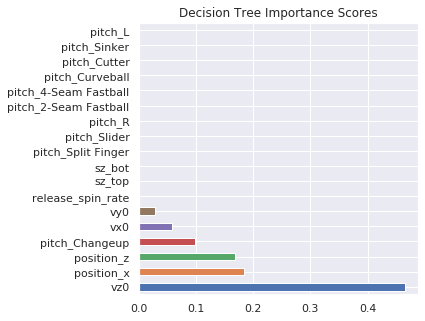

In [56]:
#show feature importances
fig = plt.figure(figsize = (5,5))
importances = pd.Series(tree_pipe_no_pca_results['estimator'][0][1].feature_importances_, index=X_train.columns) \
.sort_values(ascending = False).plot(kind = 'barh', title='Decision Tree Importance Scores')
fig.savefig('images/decision_tree_importance.png', bbox_inches = 'tight')

## Interpretation

This decision tree is showing that there are only a few informative features, including 'vz0', 'position_x' and 'position_z'. The velocity of the ball in the z dimension is the strongest predictor, as it is the first node. What we can infer from this is that if the ball has a velocity in the z-dimension that is too negatively large, i.e. it is going downward at too fast a rate, it is predicted as ball, which makes sense. The tree appears to be better able to predict a ball than a strike. 

As for deciding if the pitch is classified as a strike, if the pitch is not moving downward at that velocity and the pitch is not deemed a changeup, this appears to be one of the most important conditions. Additionally, it thinks that if the above two conditions are also true, and if the velocity in the x-dimension, or the lateral movement (from the catcher's perspective) is below 9.23 ft/s moving to the right, then the model will classify it as a strike. Still, we intuitevly know that for features involved with a pitch like movement of the pitch, there is more likely a range of values that are key indicators, not just a threshold value. Trying to determine key ranges of values for features is difficult in a decision tree. 

We must also keep in mind that the performance of this individual model is very weak. Part of the reason for this is that in order to visualize a tree, the depth of the tree must be limited in order for it to be interpreted by a human subject. This limiting of the tree and its subsequent lack of performance is supported by the sample sizes in various splits in the diagram above. The tree is much better at choosing splitting points for classifying a called ball; the entropy values for numerous nodes are much lower for called balls than entropy values for called strikes. Thus, there is a catch-22: in order to trust that the results our single decision tree provides us, we would want to visualize it and ensure that it's splitting points are appropriate. However, in order to do so, the depth of the tree has to be limited to a value so as to allow a tree to be visualized and understood. This limitation can hinder the performance of the tree, and thus with a lower peformance, we will be less trustworthy of accepting the information that the tree can give us. 



## With PCA


In [19]:
tree_pipe_with_pca_cv_results_lst = []
for n_components in [2,3,4,5,6]:
    print(f"Number of Components: {n_components}")
    print('-'*75)
    print()
    pca = PCA(n_components=n_components)
    
    pipe = Pipeline(steps = [
        ('sampler', sampler), #RandomUnderSampler(ratio = 1, random_state = 777)
        ('pca', pca),
        ('tree', tree)
    ])
    
    tree_pipe_with_pca_results = cross_validate(pipe, X_train, y_train, scoring = ['accuracy', 'f1', 'roc_auc'], 
                                cv =5, return_estimator=True, return_train_score = True)

    tree_pipe_with_pca_cv_results_lst.append(tree_pipe_with_pca_results)
    for result in ['train_accuracy', 'test_accuracy', 'train_f1', 'test_f1', 'train_roc_auc', 'test_roc_auc']:
        print(f"Mean {result} Value: {np.mean(tree_pipe_with_pca_results[result])}")
        print(f"{result} scores: {tree_pipe_with_pca_results[result]}")
        print() 

Number of Components: 2
---------------------------------------------------------------------------

Mean train_accuracy Value: 0.48795954874166403
train_accuracy scores: [0.51869713 0.49297705 0.4078715  0.52523256 0.4950195 ]

Mean test_accuracy Value: 0.48340881863240137
test_accuracy scores: [0.50964478 0.49072415 0.40149679 0.51786655 0.49731183]

Mean train_f1 Value: 0.4490081213878291
train_f1 scores: [0.4351806  0.45034853 0.48453218 0.42748189 0.44749741]

Mean test_f1 Value: 0.4449996208393919
test_f1 scores: [0.42878193 0.44570642 0.47989374 0.41843611 0.45217991]

Mean train_roc_auc Value: 0.5431356048394494
train_roc_auc scores: [0.54541157 0.54293396 0.54065618 0.54509222 0.54158409]

Mean test_roc_auc Value: 0.537282400318438
test_roc_auc scores: [0.53498736 0.53719854 0.5354318  0.53518396 0.54361035]

Number of Components: 3
---------------------------------------------------------------------------

Mean train_accuracy Value: 0.5208261778758854
train_accuracy scores: 

In [20]:
best_tree_pipe_with_pca_predictions = tree_pipe_with_pca_cv_results_lst[-2]['estimator'][0].predict(X_test)

eval_test_set(best_tree_pipe_with_pca_predictions, y_test)

Accuracy Score: 0.7390823135059925

AUC Score: 0.7591955440258685

F1 Score: 0.6682214805581246

Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.70      0.79     21437
           1       0.57      0.82      0.67     10186

    accuracy                           0.74     31623
   macro avg       0.73      0.76      0.73     31623
weighted avg       0.79      0.74      0.75     31623


 Confustion Matrix: 
 [[15063  6374]
 [ 1877  8309]]


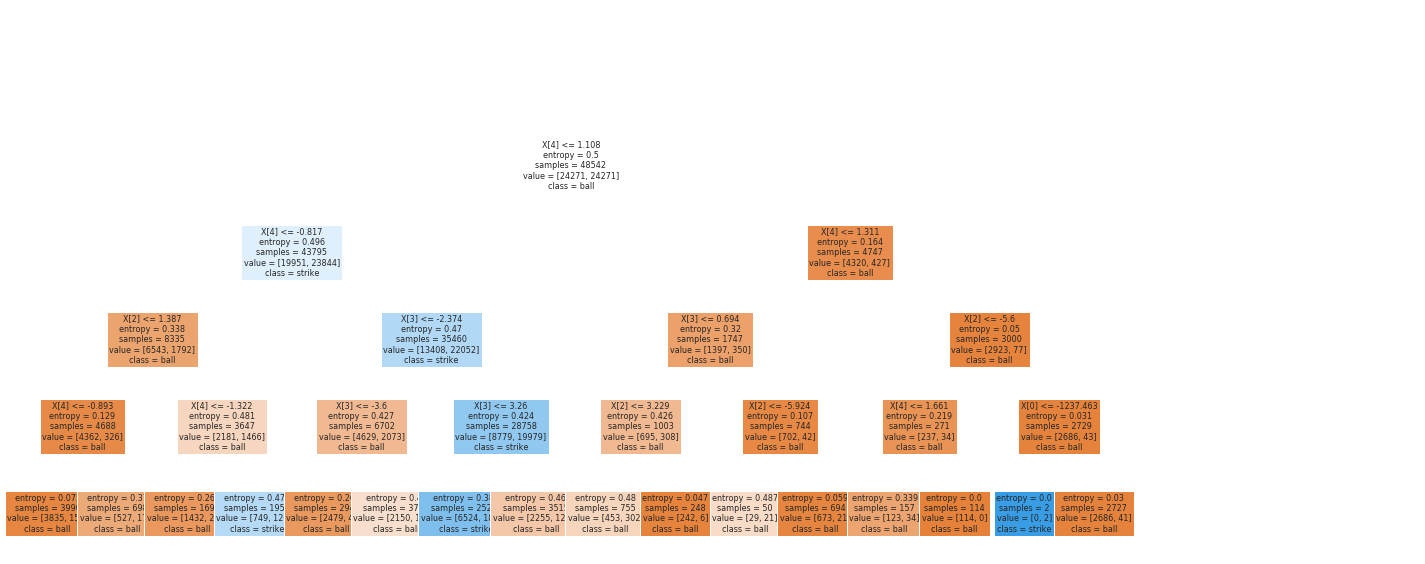

In [68]:
fig = plt.figure(figsize = (20, 8))
img = plot_tree(tree_pipe_with_pca_cv_results_lst[-2]['estimator'][0]['tree'],  class_names = ['ball', 'strike'], filled=True, fontsize = 8)
plt.tight_layout()
fig.savefig('pca_decision_tree.png')



## Find Principle components

In [66]:
tree_pipe_with_pca_cv_results_lst[-2]['estimator'][0]['pca'].components_[3]

array([-4.14781003e-02, -1.40081397e-01, -7.42736089e-04, -2.20757619e-02,
       -2.45802417e-01,  9.57687797e-01, -4.16594199e-03,  4.16594199e-03,
        3.79299419e-03, -3.76973225e-04, -1.09448404e-02,  3.48291108e-03,
       -2.45401524e-03,  1.76677801e-02, -8.93775880e-03, -2.21770232e-03])

In [53]:
tree_pipe_with_pca_cv_results_lst[-2]['estimator'][0]['pca'].singular_values_

array([66468.07021852,  2010.70701194,  1411.20620127,   601.97201042,
         190.64637658])

In [42]:
tree_pipe_with_pca_cv_results_lst[-2]['estimator'][0]['pca'].singular_values_[0]

66468.07021852434

In [33]:
tree_pipe_with_pca_cv_results_lst[-2]['estimator'][0]['pca'].components_.shape

(5, 16)

In [44]:
#re-transform
x_pca = tree_pipe_with_pca_cv_results_lst[-2]['estimator'][0]['pca'].transform(X_train)
X_projected = tree_pipe_with_pca_cv_results_lst[-2]['estimator'][0]['pca'].inverse_transform(x_pca)
X_projected.shape

(94868, 16)

In [45]:
X_projected[0]

array([-2.03069034e+00,  6.69705641e+00,  2.52499992e+03,  3.70189345e+00,
       -1.35758692e+02, -3.97025995e+00,  9.10248252e-02,  9.08975175e-01,
        1.46566618e-01,  6.09716555e-01, -1.00150310e-01,  6.13747007e-02,
        7.45368205e-02,  1.19535919e-01,  1.18615522e-01, -3.01798552e-02])